In [1]:
import os
import sys
import pytz
import argparse
# import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
from tqdm import tqdm
from geopy import distance
import datetime
import tilemapbase
from copy import deepcopy
import pickle as pkl
from PIL import Image
import skimage.measure
import math
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
os.environ['PYTHONWARNINGS']='ignore'
import hyperopt
from joblib import Parallel, delayed
import random
random.seed(42)
import scipy
import torch
from pykrige.ok import OrdinaryKriging
from pykrige.ok3d import OrdinaryKriging3D
from pykrige.uk import UniversalKriging
from sklearn.model_selection import train_test_split
from scipy.interpolate import CubicSpline
import scipy.ndimage
import scipy.stats
import scipy.optimize

In [2]:
source = 'combined'
sensor = 'pm25'
res_time = '1H'
filepath_root = '/scratch/ab9738/pollution_with_sensors/'
filepath_data_kai = filepath_root+'data/kaiterra/kaiterra_fieldeggid_{}_current_panel.csv'.format(res_time)
filepath_data_gov = filepath_root+'data/govdata/govdata_{}_current.csv'.format(res_time)
filepath_locs_kai = filepath_root+'data/kaiterra/kaiterra_locations.csv'
filepath_locs_gov = filepath_root+'data/govdata/govdata_locations.csv'

filepath_data_kai = filepath_root+'data/kaiterra/kaiterra_fieldeggid_{}_current_panel.csv'.format(res_time)
filepath_data_gov = filepath_root+'data/govdata/govdata_{}_current.csv'.format(res_time)
filepath_locs_kai = filepath_root+'data/kaiterra/kaiterra_locations.csv'
filepath_locs_gov = filepath_root+'data/govdata/govdata_locations.csv'

locs_kai = pd.read_csv(filepath_locs_kai, index_col=[0])
locs_kai['Type'] = 'Kaiterra'
locs_gov = pd.read_csv(filepath_locs_gov, index_col=[0])
locs_gov['Type'] = 'Govt'
locs = pd.merge(locs_kai, locs_gov, how='outer',\
                on=['Monitor ID', 'Latitude', 'Longitude', 'Location', 'Type'], copy=False)
data_kai = pd.read_csv(filepath_data_kai, index_col=[0,1], parse_dates=True)[sensor]
data_gov = pd.read_csv(filepath_data_gov, index_col=[0,1], parse_dates=True)[sensor]
data = pd.concat([data_kai, data_gov], axis=0, copy=False)
data.replace(0,np.nan,inplace=True)

start_dt = data.index.levels[1][0]
end_dt = data.index.levels[1][-1]

if start_dt.tzname != 'IST':
        if start_dt.tzinfo is None:
            start_dt = start_dt.tz_localize('UTC')
        start_dt = start_dt.tz_convert(pytz.FixedOffset(330))
    
if end_dt.tzname != 'IST':
    if end_dt.tzinfo is None: 
        end_dt = end_dt.tz_localize('UTC')
    end_dt = end_dt.tz_convert(pytz.FixedOffset(330))

# now, filter through the start and end dates
data.sort_index(inplace=True)
data = data.loc[(slice(None), slice(start_dt, end_dt))]

if(source=='govdata'):
    df = data_gov.unstack(level=0)
elif(source=='kaiterra'):
    df = data_kai.unstack(level=0)
else:
    df = data.unstack(level=0)
distances = pd.read_csv('/scratch/ab9738/pollution_with_sensors/data/combined_distances.csv', index_col=[0])
distances = distances.loc[df.columns, df.columns]
distances[distances == 0] = np.nan

In [3]:
df = df.drop(['Pusa_IMD'], axis=1)

In [4]:
df_ws = pd.read_csv('/scratch/ab9738/pollution_with_sensors/hotspots/source_apportionment/wind_speeds.csv', parse_dates=True)
df_ws = df_ws.sort_values(['Timestamp']).reset_index(drop=True)
df_ws = df_ws.set_index(pd.DatetimeIndex(df_ws['Timestamp']))
df_ws = df_ws[['u-component', 'v-component']].groupby('Timestamp').mean()

In [5]:
brick_kilns = np.load('../source_apportionment/brick_kilns_intensity_80x80.npy')
industries = np.load('../source_apportionment/industries_intensity_80x80.npy')
power_plants = np.load('../source_apportionment/power_plants_intensity_80x80.npy')
population_density = np.load('../source_apportionment/population_density_intensity_80x80.npy')
traffic_06 = np.load('../source_apportionment/traffic_06_intensity_80x80.npy')
traffic_12 = np.load('../source_apportionment/traffic_12_intensity_80x80.npy')
traffic_18 = np.load('../source_apportionment/traffic_18_intensity_80x80.npy')
traffic_00 = np.load('../source_apportionment/traffic_00_intensity_80x80.npy')

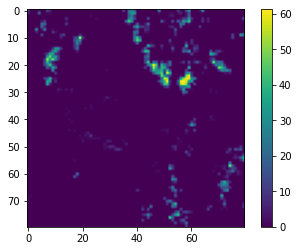

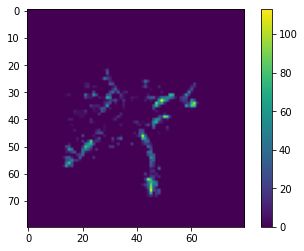

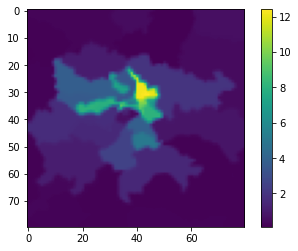

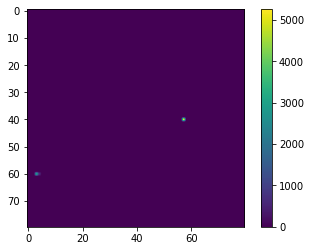

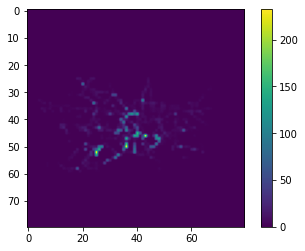

In [6]:
def heatmap2d(arr: np.ndarray):
    fig = plt.figure()
    plt.imshow(arr, cmap='viridis', origin='upper')
    plt.colorbar()
    plt.show()
    plt.close(fig)
    
    
heatmap2d(brick_kilns)
heatmap2d(industries)
heatmap2d(population_density)
heatmap2d(power_plants)
heatmap2d(traffic_18)

In [7]:
brick_kilns = torch.unsqueeze(torch.unsqueeze(torch.tensor(brick_kilns,dtype=torch.float),0),0).cuda()
industries = torch.unsqueeze(torch.unsqueeze(torch.tensor(industries,dtype=torch.float),0),0).cuda()
power_plants = torch.unsqueeze(torch.unsqueeze(torch.tensor(power_plants,dtype=torch.float),0),0).cuda()
population_density = torch.unsqueeze(torch.unsqueeze(torch.tensor(population_density,dtype=torch.float),0),0).cuda()
traffic_06 = torch.unsqueeze(torch.unsqueeze(torch.tensor(traffic_06,dtype=torch.float),0),0).cuda()
traffic_12 = torch.unsqueeze(torch.unsqueeze(torch.tensor(traffic_12,dtype=torch.float),0),0).cuda()
traffic_18 = torch.unsqueeze(torch.unsqueeze(torch.tensor(traffic_18,dtype=torch.float),0),0).cuda()
traffic_00 = torch.unsqueeze(torch.unsqueeze(torch.tensor(traffic_00,dtype=torch.float),0),0).cuda()

In [8]:
def cell_to_cord(i,j,size):
    return(j, size-1-i)
def cord_to_cell(x,y,size):
    return(size-1-y, x)

In [9]:
def gpdm_filter(wind_vector, size):
    filt = np.zeros((size,size))
    dest_i, dest_j = int(size/2), int(size/2)
    dest_x, dest_y = cell_to_cord(dest_i, dest_j, size)
    for i in range(size):
        for j in range(size):
            src_i, src_j = i, j
            src_x, src_y = cell_to_cord(i,j,size)
            unit_wind_vector = wind_vector/np.linalg.norm(wind_vector)
            wind_magnitude = np.linalg.norm(wind_vector)
            if(dest_x!=src_x or dest_y!=src_y):
                distance_vector = np.array([dest_x-src_x, dest_y-src_y])*math.pow(10,3)
                dist_wind = np.dot(distance_vector, unit_wind_vector)
                if(dist_wind<=0):
                    filt[src_i,src_j] = 0
                else:
                    distance_magnitude = np.linalg.norm(distance_vector)
                    dist_per = math.pow(max(math.pow(distance_magnitude,2)-math.pow(dist_wind,2),0),0.5)
                    sigma_y = 213*math.pow(dist_wind*0.001,0.894)
                    baseline_dist = 707
                    dist_wind = max(dist_wind/baseline_dist,1)
                    if(dist_per<650):
                        filt[src_i,src_j] = 1/((dist_wind**3)*wind_magnitude)
                    else:
                        filt[src_i,src_j] = 0
            else:
                filt[src_i,src_j] = 1/(wind_magnitude)        
    return(filt)

In [10]:
def get_wind_vector(ts):
    ts = np.array([ts]).astype('datetime64[ns]')[0]
    cts = min(df_ws.index, key=lambda x:abs(x-ts))
    idx = df_ws.index.to_list().index(cts)
    v1 = df_ws.iloc[idx].values
    if((cts-ts).total_seconds()>0):
        v2 = df_ws.iloc[idx-1].values
    else:
        v2 = df_ws.iloc[idx+1].values
    ws = v1+((v2-v1)*(abs((cts-ts).total_seconds())/(3600*6)))
    ws = ws*(5.0/18)
    return(ws)

In [11]:
def compute_filters(ts_array):
    src_radius = 4
    ts_filters = []
    for ts in ts_array:
        wind_vector = get_wind_vector(ts)
        ts_filters.append(gpdm_filter(wind_vector, 2*src_radius+1))
    return(ts_filters)

In [12]:
def convolve_at_sensors(sensors, ts_array, alpha, ts_filter):    
    
    concentrations_at_sensors = []
    src_radius = 4
    
    for sensor in sensors:
        dest = (locs.loc[sensor]['Latitude'], locs.loc[sensor]['Longitude'])
        idx_x = int((dest[1]-76.85)/0.01)
        idx_y = 79-int((dest[0]-28.2)/0.01)
        
        contrib_brick = torch.nn.functional.conv2d(ts_filter, \
                                                   brick_kilns[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_industry = torch.nn.functional.conv2d(ts_filter, \
                                                   industries[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_population = torch.nn.functional.conv2d(ts_filter, \
                                                   population_density[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_traffic_06 = torch.nn.functional.conv2d(ts_filter, \
                                                   traffic_06[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_traffic_00 = torch.nn.functional.conv2d(ts_filter, \
                                                   traffic_00[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_traffic_12 = torch.nn.functional.conv2d(ts_filter, \
                                                   traffic_12[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_traffic_18 = torch.nn.functional.conv2d(ts_filter, \
                                                   traffic_18[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_power = torch.nn.functional.conv2d(ts_filter, \
                                                   power_plants[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        
        contrib_traffic = torch.zeros_like(contrib_traffic_06)
        for i in range(len(ts_array)):
            ts = ts_array[i]
            if(pd.Timestamp(ts).hour>3 and pd.Timestamp(ts).hour<9):
                contrib_traffic[i] = contrib_traffic_06[i]
            elif(pd.Timestamp(ts).hour>=9 and pd.Timestamp(ts).hour<15):
                contrib_traffic[i] = contrib_traffic_12[i]
            elif(pd.Timestamp(ts).hour>=15 and pd.Timestamp(ts).hour<21):
                contrib_traffic[i] = contrib_traffic_18[i]
            else:
                contrib_traffic[i] = contrib_traffic_00[i]
            
        total_concentration = alpha*(contrib_brick + contrib_industry + contrib_traffic + contrib_power +contrib_population)
        # total_concentration = alpha['unknown']*contrib_unknown
        total_concentration = torch.squeeze(total_concentration)
        concentrations_at_sensors.append(total_concentration)
    return(concentrations_at_sensors)

In [13]:
ts_array = np.array(list(set(data.dropna().index.get_level_values("timestamp_round").to_numpy())))
ts_array = np.sort(ts_array)

In [14]:
ts_filters = compute_filters(ts_array)

In [20]:
ts_filters = torch.tensor(ts_filters)
ts_filters = torch.unsqueeze(ts_filters,1)
ts_filters = ts_filters.cuda().float()

In [26]:
alpha = 1
comp, mes = 0,0
sensors = df.columns
comp_values = torch.stack(convolve_at_sensors(sensors, ts_array, alpha, ts_filters),1)
mes_values = torch.tensor(df.to_numpy()).cuda()
mask = ~mes_values.isnan()
mask = mask.long()
comp_values = comp_values*mask

In [27]:
mes_values

tensor([[     nan,      nan,      nan,  ...,      nan,  70.0000,  94.0000],
        [     nan,      nan,      nan,  ...,      nan,  59.0000,  77.0000],
        [     nan,      nan,      nan,  ...,      nan,  52.0000,  64.0000],
        ...,
        [     nan,      nan,      nan,  ..., 129.0000, 214.0000, 149.0000],
        [     nan,      nan,      nan,  ..., 164.2500, 276.5000, 196.0000],
        [     nan,      nan,      nan,  ..., 236.5000, 372.0000, 246.0000]],
       device='cuda:0', dtype=torch.float64)

In [28]:
comp_values

tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   3.8940,  75.9347],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,  11.2738, 235.0891],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,  26.5077, 151.0218],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,  18.9007,   3.0100,  58.8579],
        [  0.0000,   0.0000,   0.0000,  ...,  18.3380,   2.9430,  57.8773],
        [  0.0000,   0.0000,   0.0000,  ...,  18.2803,   2.9130,  57.0482]],
       device='cuda:0')

In [29]:
mes = torch.nansum(mes_values)
comp = torch.sum(comp_values)
print(mes/comp)

tensor(2.7634, device='cuda:0', dtype=torch.float64)


In [31]:
df_comp = pd.DataFrame(comp_values.cpu().numpy())
df_comp.columns = df.columns

In [36]:
df_comp.index = df.index

In [40]:
mes, comp = 0, 0
for idx,row in df.iterrows():
    y = row.values
    pred = df_comp.loc[idx].values
    
    pred = pred[~np.isnan(y)]
    y = y[~np.isnan(y)]
    
    y_train, y_test, pred_train, pred_test = train_test_split(
        y, pred, test_size=0.2, random_state=40
    )
    
    y_train_sum = np.sum(y_train)
    pred_train_sum = np.sum(pred_train)
    mes += y_train_sum
    comp += pred_train_sum
print(mes/comp)

2.799231754088503


In [41]:
alpha = mes/comp

In [48]:
ape, se = [], []
for idx,row in df.iterrows():
    y = row.values
    pred = df_comp.loc[idx].values
    
    pred = pred[~np.isnan(y)]
    y = y[~np.isnan(y)]
    
    y_train, y_test, pred_train, pred_test = train_test_split(
        y, pred, test_size=0.2, random_state=44
    )
    
    ape_for_row = np.abs((y_test-pred_test)/y_test)
    se_for_row = np.square(y_test-pred_test)
    
    ape.append(ape_for_row)
    se.append(se_for_row)
    
ape_arr = np.concatenate(ape)
se_arr = np.concatenate(se)
mape = np.mean(ape_arr)
rmse = np.sqrt(np.mean(se_arr))
print(mape, rmse)

1.040497498043367 153.522362455785


In [50]:
a = np.array([166.78276119258237,161.22940371726145,152.53931367957262,157.89862620721755,153.522362455785])
print(a.mean(),a.std())

158.3944934504838 5.228124459802954
